<b>Исследование данных о продажах интернет-магазина «В один клик» для разработки решения, которое позволит увеличить активность покупателей</b>

## Подготовка

Загружаем требуемые модули

In [1]:
#!pip install phik 
#!pip install shap 
#!pip install matplotlib==3.5.0

Загружаем требуемые библиотеки

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns
pd.set_option('display.max_columns', None)

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
import shap

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

In [3]:
# 1.1 Загрузим данные
market_file = pd.read_csv('datasets/market_file.csv')
market_money = pd.read_csv('datasets/market_money.csv')
market_time = pd.read_csv('datasets/market_time.csv')
money = pd.read_csv('datasets/money.csv', sep=';', decimal=',')

In [4]:
# Таблица, которая содержит данные о поведении покупателя на сайте, 
# о коммуникациях с покупателем и его продуктовом поведении
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
market_file.columns = market_file.columns.str.replace("[ ]", "_", regex=True)

In [6]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [7]:
# Таблица с данными о выручке, которую получает магазин с покупателя, 
# то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
# Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
# Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: 
# какую прибыль получает магазин от продаж каждому покупателю.
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Выполнена проверка: данные в таблицах соответствуют описанию

## Предобработка данных

Проведем необходимую предобработку данных. Названия столбцов оставим кириллическими

Проверим данные на наличие пропусков

In [10]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [11]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [12]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [13]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Пропусков нет.

Проверим данные на наличие дубликатов

In [14]:
market_file.duplicated().sum()

0

In [15]:
market_money.duplicated().sum()

0

In [16]:
market_time.duplicated().sum()

0

In [17]:
money.duplicated().sum()

0

In [18]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Исследуем значения категориальных признаков

In [19]:
print(market_file['Покупательская_активность'].unique())
print(market_file['Тип_сервиса'].unique())
print(market_file['Разрешить_сообщать'].unique())
print(market_file['Популярная_категория'].unique())
print(market_money['Период'].unique())
print(market_time['Период'].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
['текущий_месяц' 'предыдцщий_месяц']


Устраним неявные дубликаты, скорректируем значения и проверим результат

In [20]:
market_file['Покупательская_активность'] = market_file['Покупательская_активность'].str.replace('прежний уровень', 'прежний_уровень', regex=True)
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].str.replace('стандартт', 'стандарт', regex=True)

market_file = market_file.replace({'Популярная_категория': {
    'Товары для детей':'товары_для_детей', 
    'Домашний текстиль':'домашний_текстиль',
    'Косметика и аксесуары':'косметика_и_аксесуары',
    'Техника для красоты и здоровья':'техника_для_красоты_и_здоровья',
    'Кухонная посуда':'кухонная_посуда',
    'Мелкая бытовая техника и электроника':'мелкая_бытовая_техника_и_электроника'
}})

market_money['Период'] = market_money['Период'].str.replace('препредыдущий_месяц', 'предпредыдущий_месяц', regex=True)
market_time['Период'] = market_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц', regex=True)
market_file['Покупательская_активность'] = market_file['Покупательская_активность'].str.lower()
market_file['Разрешить_сообщать'] = market_file['Разрешить_сообщать'].str.lower()

print(market_file['Покупательская_активность'].unique())
print(market_file['Тип_сервиса'].unique())
print(market_file['Разрешить_сообщать'].unique())
print(market_file['Популярная_категория'].unique())
print(market_money['Период'].unique())
print(market_time['Период'].unique())

['снизилась' 'прежний уровень']
['премиум' 'стандарт']
['да' 'нет']
['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника_и_электроника']
['предпредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
['текущий_месяц' 'предыдущий_месяц']


Проверим типы данных

In [21]:
market_file.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2


In [22]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [23]:
market_money.head()

,id,Период,Выручка
0,215348,предпредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,предпредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [24]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [25]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [26]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [27]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [28]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Вывод**

Пропусков в данных - нет.
Дубликаты найдены и устранены.
Типы данных - корректные.

## Исследовательский анализ данных

Проведем статистический анализ всех признаков

In [29]:
market_file.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


In [30]:
market_money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


In [31]:
market_time.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


In [32]:
money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


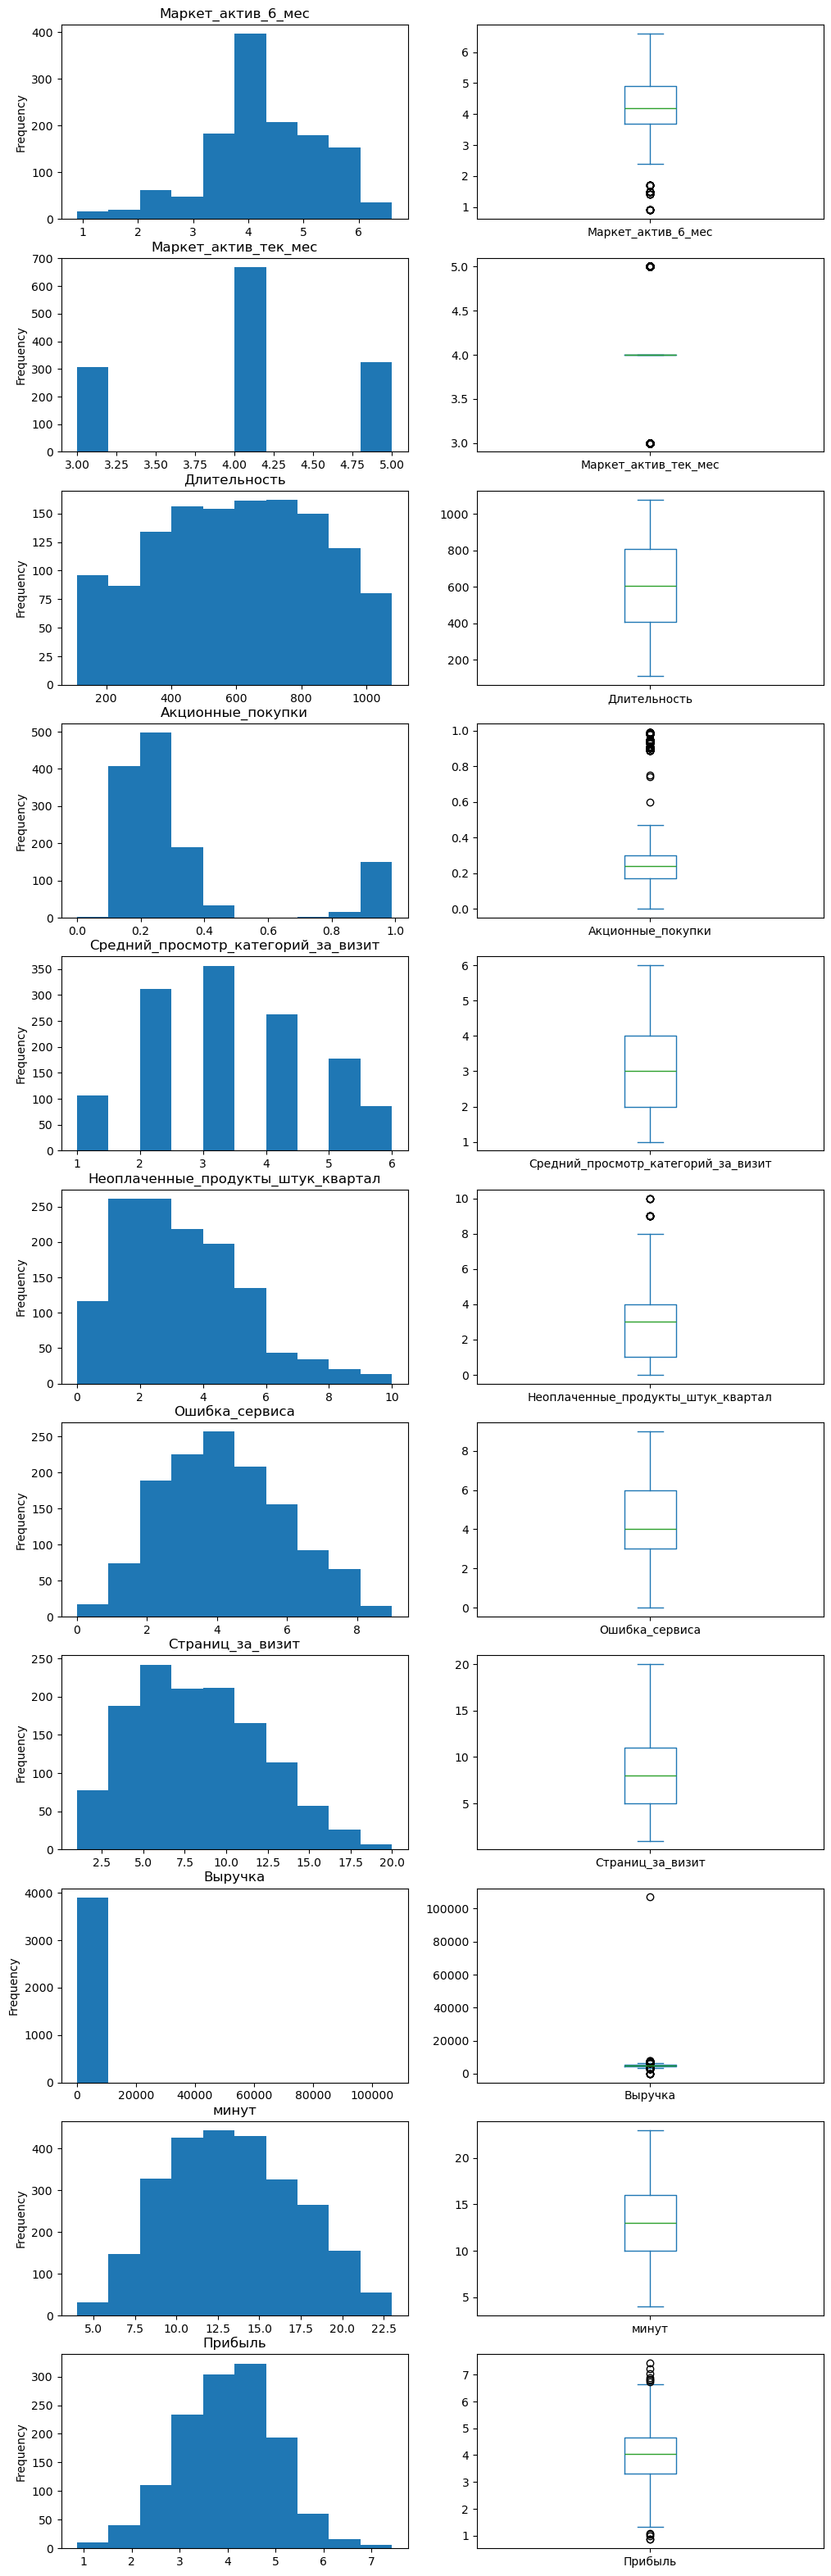

In [33]:
# количественные признаки
fig, ax = plt.subplots(nrows=11, ncols=2, figsize=(12,40))
ax = ax.flatten()

market_file['Маркет_актив_6_мес'].plot(kind='hist', ax=ax[0], rot=0)
ax[0].set_title("Маркет_актив_6_мес");
market_file['Маркет_актив_6_мес'].plot(kind='box', ax=ax[1], rot=0)

market_file['Маркет_актив_тек_мес'].plot(kind='hist', ax=ax[2], rot=0)
ax[2].set_title("Маркет_актив_тек_мес");
market_file['Маркет_актив_тек_мес'].plot(kind='box', ax=ax[3], rot=0)

market_file['Длительность'].plot(kind='hist', ax=ax[4], rot=0)
ax[4].set_title("Длительность");
market_file['Длительность'].plot(kind='box', ax=ax[5], rot=0)

market_file['Акционные_покупки'].plot(kind='hist', ax=ax[6], rot=0)
ax[6].set_title("Акционные_покупки");
market_file['Акционные_покупки'].plot(kind='box', ax=ax[7], rot=0)

market_file['Средний_просмотр_категорий_за_визит'].plot(kind='hist', ax=ax[8], rot=0)
ax[8].set_title("Средний_просмотр_категорий_за_визит");
market_file['Средний_просмотр_категорий_за_визит'].plot(kind='box', ax=ax[9], rot=0)

market_file['Неоплаченные_продукты_штук_квартал'].plot(kind='hist', ax=ax[10], rot=0)
ax[10].set_title("Неоплаченные_продукты_штук_квартал");
market_file['Неоплаченные_продукты_штук_квартал'].plot(kind='box', ax=ax[11], rot=0)

market_file['Ошибка_сервиса'].plot(kind='hist', ax=ax[12], rot=0)
ax[12].set_title("Ошибка_сервиса");
market_file['Ошибка_сервиса'].plot(kind='box', ax=ax[13], rot=0)

market_file['Страниц_за_визит'].plot(kind='hist', ax=ax[14], rot=0)
ax[14].set_title("Страниц_за_визит");
market_file['Страниц_за_визит'].plot(kind='box', ax=ax[15], rot=0)

market_money['Выручка'].plot(kind='hist', ax=ax[16], rot=0)
ax[16].set_title("Выручка");
market_money['Выручка'].plot(kind='box', ax=ax[17], rot=0)

market_time['минут'].plot(kind='hist', ax=ax[18], rot=0)
ax[18].set_title("минут");
market_time['минут'].plot(kind='box', ax=ax[19], rot=0)

money['Прибыль'].plot(kind='hist', ax=ax[20], rot=0)
ax[20].set_title("Прибыль");
money['Прибыль'].plot(kind='box', ax=ax[21], rot=0);

Посмотрим пристальнее на выручку. Отфильтруем аномальные значения 

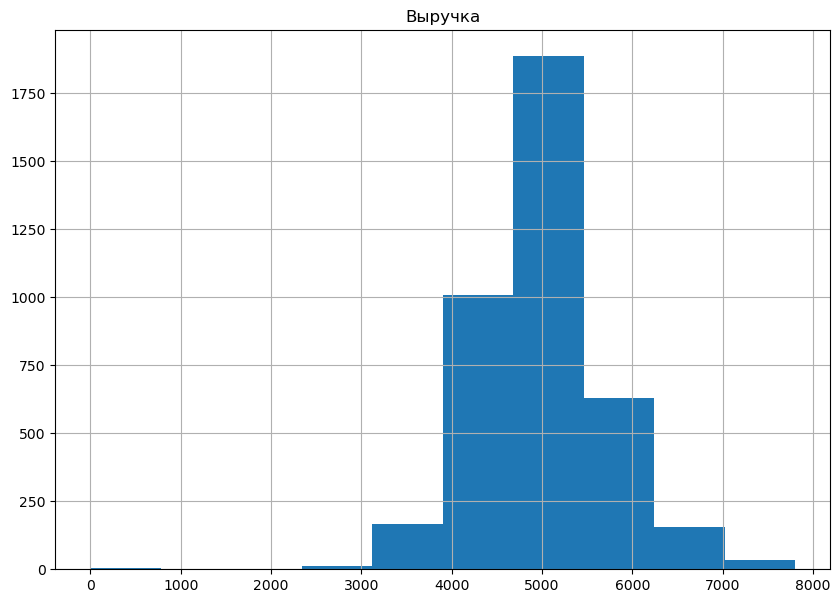

In [34]:
market_money[['Выручка']].query('Выручка < 20000').hist(figsize=(10,7));

In [35]:
# Удалим выброс
market_money = market_money.query('Выручка < 20000')

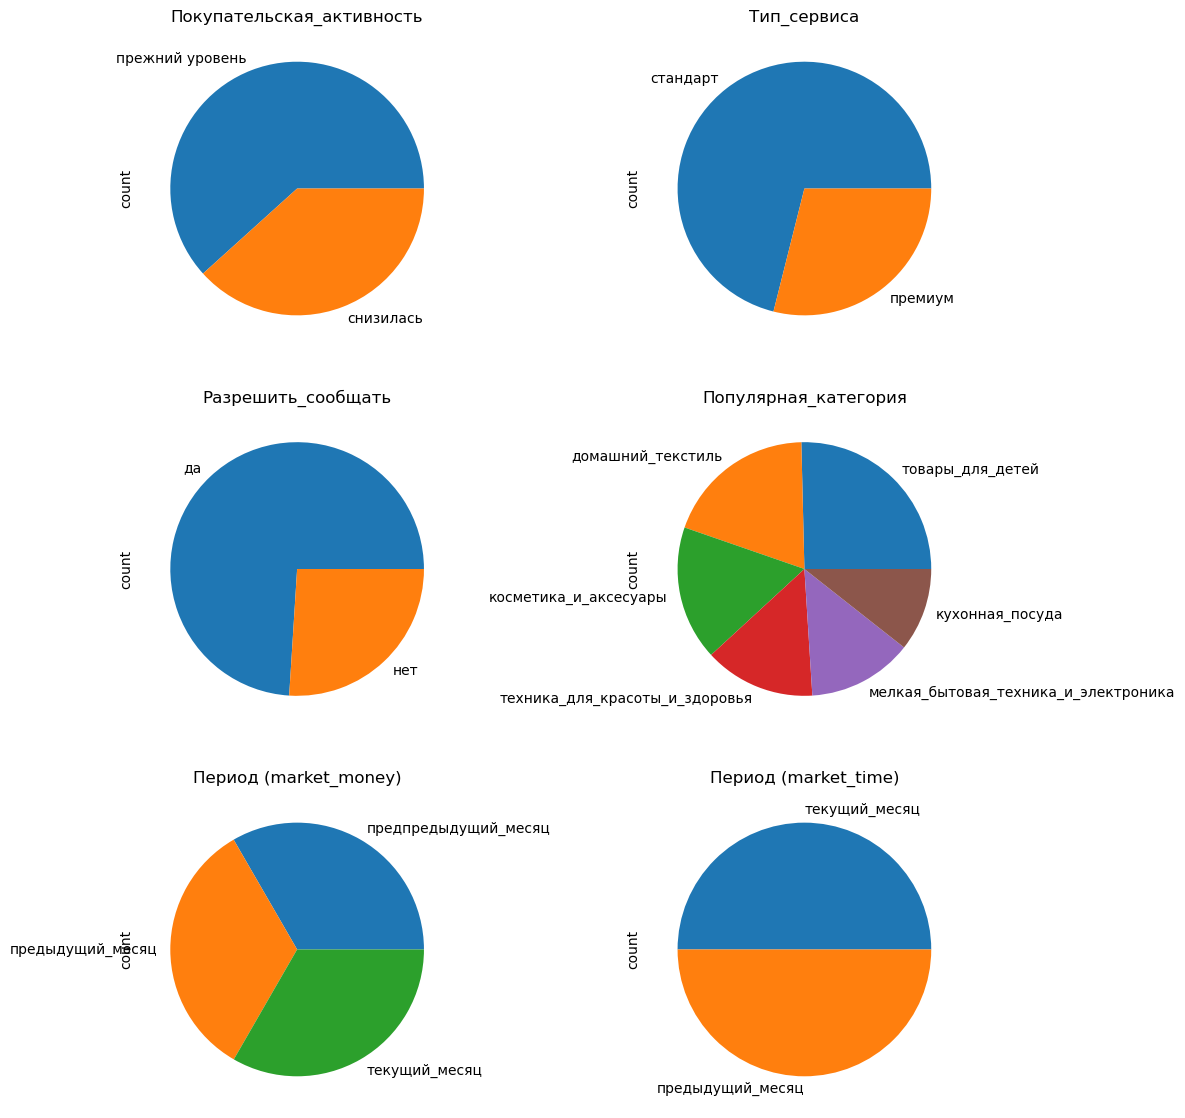

In [36]:
# категориальные признаки
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
ax = ax.flatten()

market_file['Покупательская_активность'].value_counts().plot(kind='pie', ax=ax[0], rot=0)
ax[0].set_title("Покупательская_активность");
market_file['Тип_сервиса'].value_counts().plot(kind='pie', ax=ax[1], rot=0)
ax[1].set_title("Тип_сервиса");
market_file['Разрешить_сообщать'].value_counts().plot(kind='pie', ax=ax[2], rot=0)
ax[2].set_title("Разрешить_сообщать");
market_file['Популярная_категория'].value_counts().plot(kind='pie', ax=ax[3], rot=0)
ax[3].set_title("Популярная_категория");
market_money['Период'].value_counts().plot(kind='pie', ax=ax[4], rot=0)
ax[4].set_title("Период (market_money)");
market_time['Период'].value_counts().plot(kind='pie', ax=ax[5], rot=0)
ax[5].set_title("Период (market_time)");

Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

In [37]:
market_money.shape

(3899, 3)

In [38]:
market_money = market_money.query('Выручка > 0')

In [39]:
market_money.shape

(3893, 3)

In [40]:
market_file = market_file.query('id in @market_money.id')
market_time = market_time.query('id in @market_money.id')

**Выводы**

- имеются выбросы в признаках: Маркет_актив\_6_мес, Маркет_актив_тек_мес, Акционные_покупки, Неоплаченные_продукты_штук_квартал, Выручка, Прибыль

- дисбаланс имеется в признаках: Покупательская активность (дисбаланс небольшой, к тому же это целевой признак), Разрешить сообщать, Тип сервиса.
 


Приведем значения поля "Покупательская_активность" к числовому типу

In [41]:
market_file['Покупательская_активность'] = market_file['Покупательская_активность'].replace('снизилась', '1', regex=True)
market_file['Покупательская_активность'] = market_file['Покупательская_активность'].replace('прежний уровень', '0', regex=True)
market_file['Покупательская_активность'] = market_file['Покупательская_активность'].astype(int)
print(market_file['Покупательская_активность'].unique())

[1 0]


## Объединение таблиц

Учтем, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. 
Сделаем отдельный столбец для каждого периода

In [42]:
market_money_curr = market_money.query('Период == "текущий_месяц"')
market_money_curr = market_money_curr.rename(columns={'Выручка': 'Выручка_текущий_месяц'})
market_money_curr = market_money_curr.drop('Период', axis=1)

market_money_prev = market_money.query('Период == "предыдущий_месяц"') 
market_money_prev = market_money_prev.rename(columns={'Выручка': 'Выручка_предыдущий_месяц'})
market_money_prev = market_money_prev.drop('Период', axis=1)

market_money_prevprev = market_money.query('Период == "предпредыдущий_месяц"') 
market_money_prevprev = market_money_prevprev.rename(columns={'Выручка': 'Выручка_предпредыдущий_месяц'})
market_money_prevprev = market_money_prevprev.drop('Период', axis=1)

market_money = market_money_curr.merge(market_money_prev, on='id', how='left')
market_money = market_money.merge(market_money_prevprev, on='id', how='left')
market_money.head()

,id,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_предпредыдущий_месяц
0,215348,3293.1,NaN,NaN
1,215349,4971.6,5216.0,4472.0
2,215350,5058.4,5457.5,4826.0
3,215351,6610.4,6158.0,4793.0
4,215352,5872.5,5807.5,4594.0


In [43]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [44]:
market_time_curr = market_time.query('Период == "текущий_месяц"')
market_time_curr = market_time_curr.rename(columns={'минут': 'минут_текущий_месяц'})
market_time_curr = market_time_curr.drop('Период', axis=1)

market_time_prev = market_time.query('Период == "предыдущий_месяц"') 
market_time_prev = market_time_prev.rename(columns={'минут': 'минут_предыдущий_месяц'})
market_time_prev = market_time_prev.drop('Период', axis=1)

market_time_prevprev = market_time.query('Период == "предпредыдущий_месяц"') 
market_time_prevprev = market_time_prevprev.rename(columns={'минут': 'минут_предпредыдущий_месяц'})
market_time_prevprev = market_time_prevprev.drop('Период', axis=1)

market_time = market_time_curr.merge(market_time_prev, on='id', how='left')
market_time = market_time.merge(market_time_prevprev, on='id', how='left')
market_time.head()

,id,минут_текущий_месяц,минут_предыдущий_месяц,минут_предпредыдущий_месяц
0,215348,14,13,NaN
1,215349,10,12,NaN
2,215350,13,8,NaN
3,215351,13,11,NaN
4,215352,11,8,NaN


In [45]:
df_full = market_file.merge(market_money, on='id', how='left')
df_full = df_full.merge(market_time, on='id', how='left')

In [46]:
df_full.shape[0]

1300

In [47]:
df_full.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_предпредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,минут_предпредыдущий_месяц
0,215348,1,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5,3293.1,NaN,NaN,14,13,NaN
1,215349,1,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4971.6,5216.0,4472.0,10,12,NaN
2,215350,1,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8,NaN
3,215351,1,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6610.4,6158.0,4793.0,13,11,NaN
4,215352,1,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5872.5,5807.5,4594.0,11,8,NaN


## Корреляционный анализ

In [48]:
# Уберем ID в индекс
df_full = df_full.set_index('id')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            1300 non-null   int32  
 1   Тип_сервиса                          1300 non-null   object 
 2   Разрешить_сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int64  
 5   Длительность                         1300 non-null   int64  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  Ошибка_сервиса                       1300 non-null   int64  
 11  Страниц_за_визит            

In [49]:
df_full.shape

(1300, 18)

In [50]:
df_full = df_full.query('\
    Выручка_предыдущий_месяц.notnull() and \
    Выручка_предпредыдущий_месяц.notnull() \
    ')

In [51]:
df_full.shape

(1296, 18)

In [52]:
df_full.минут_предпредыдущий_месяц.unique()

array([nan])

In [53]:
df_full = df_full.drop('минут_предпредыдущий_месяц', axis=1)

In [54]:
df_full.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_предпредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
215350,1,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
215351,1,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
215352,1,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
215353,1,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


In [55]:
df_full.shape

(1296, 17)

In [56]:
df_full.Выручка_текущий_месяц.max()

7799.4

In [57]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            1296 non-null   int32  
 1   Тип_сервиса                          1296 non-null   object 
 2   Разрешить_сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные_покупки                    1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  Ошибка_сервиса                       1296 non-null   int64  
 11  Страниц_за_визит            

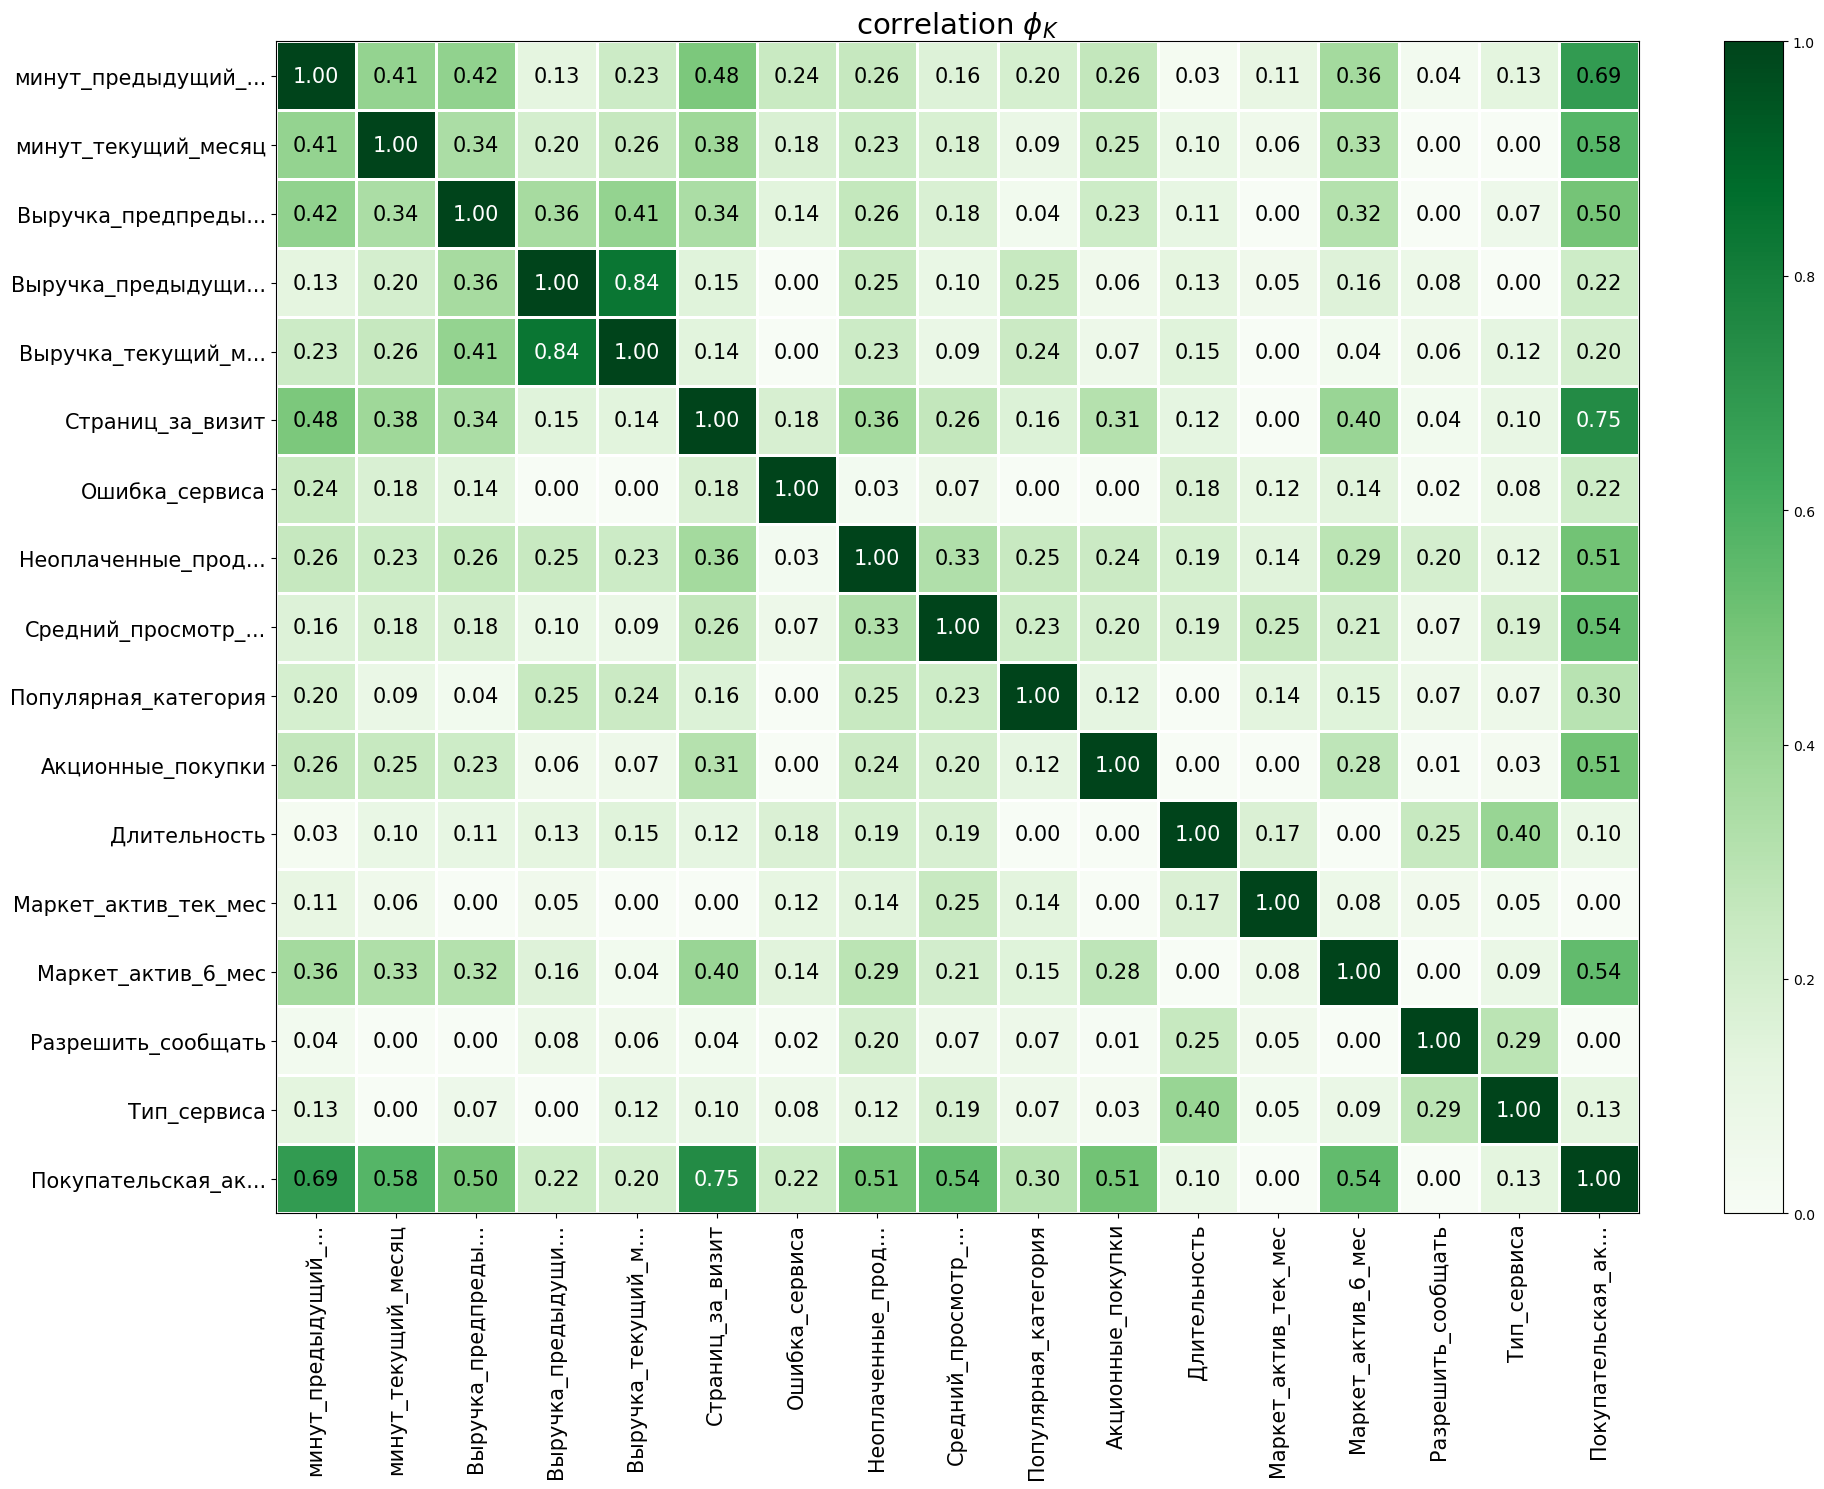

In [58]:
# оставшиеся категориальные признаки: 
#   ['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']

interval_cols = [
'Маркет_актив_6_мес',                 
'Маркет_актив_тек_мес',               
'Длительность',
'Акционные_покупки',
'Средний_просмотр_категорий_за_визит',
'Неоплаченные_продукты_штук_квартал', 
'Ошибка_сервиса',                     
'Страниц_за_визит',                   
'Выручка_текущий_месяц',              
'Выручка_предыдущий_месяц',           
'Выручка_предпредыдущий_месяц',       
'минут_текущий_месяц',                
'минут_предыдущий_месяц',             
'минут_предпредыдущий_месяц']

phik_overview = df_full.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

В таблице отсутствуют значения коллинеарности 0.9 и выше для всех пар признаков. 
Можно сделать вывод об отсутствии мультиколлинеарности.

## Выбор модели и гиперпараметров с помощью конвейеров

In [59]:
X = df_full.drop(columns=['Покупательская_активность'])
y = df_full['Покупательская_активность']

# делим данные на выборки
X_train, X_test, y_train, y_test = \
    train_test_split(
        X, 
        y, 
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE,
        stratify = df_full['Покупательская_активность']
    )

X_train.shape, X_test.shape


((972, 16), (324, 16))

In [60]:
df_full.head(10)

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_предпредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
215350,1,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
215351,1,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
215352,1,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
215353,1,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10
215354,1,стандарт,да,5.1,3,431,0.23,косметика_и_аксесуары,2,3,7,2,5869.6,5685.0,4503.0,12,11
215355,1,стандарт,нет,4.7,4,284,0.17,товары_для_детей,5,1,6,4,3772.6,3263.0,4749.0,10,12
215356,1,стандарт,да,4.2,4,192,0.14,косметика_и_аксесуары,2,2,1,3,4566.4,4146.5,4433.0,7,6
215358,1,стандарт,да,4.7,4,450,0.13,домашний_текстиль,4,2,6,4,4209.5,3488.0,4727.0,10,14


In [61]:
# создаём списки с названиями признаков
ohe_columns = ['Разрешить_сообщать', 'Популярная_категория']
ord_columns = ['Тип_сервиса']
num_columns = [
'Маркет_актив_6_мес',                 
'Маркет_актив_тек_мес',               
'Длительность',
'Акционные_покупки',
'Средний_просмотр_категорий_за_визит',
'Неоплаченные_продукты_штук_квартал', 
'Ошибка_сервиса',                     
'Страниц_за_визит',                   
'Выручка_текущий_месяц',              
'Выручка_предыдущий_месяц',           
'Выручка_предпредыдущий_месяц',       
'минут_текущий_месяц',                
'минут_предыдущий_месяц']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))
])

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord',  OrdinalEncoder(
        categories=[
            ['стандарт', 'премиум'] 
        ], 
        handle_unknown='use_encoded_value', unknown_value=np.nan
        )
    ),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели SVC()
#    {
#        'models': [SVC(
#            probability=True, 
#            random_state=RANDOM_STATE)],
#        'models__gamma': [0.1, 1, 10, 100],
#        'models__C': [0.1, 1, 10, 100],
#        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
#    }
]

Для данной задачи, при подборе гиперпараметров, используем метрику ROC-AUC.

Обоснование: эта метрика подходит для случаев, когда необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.

In [62]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [63]:
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),...
                                  

In [64]:
# проверим работу модели на тестовой выборке
# и рассчитаем прогноз на тестовых данных

#y_test_pred = randomized_search.predict(X_test)
#print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, probabilities_one)}')

Метрика ROC-AUC на тестовой выборке: 0.916879019536464


In [65]:
X_test.head()

,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_предпредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
id,,,,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,0.15,техника_для_красоты_и_здоровья,6,1,4,12,3289.2,3973.0,4912.0,17,16
215654,премиум,нет,1.4,4,684,0.94,товары_для_детей,3,6,1,6,4170.7,3548.0,4656.0,9,11
216307,премиум,да,3.3,4,488,0.13,домашний_текстиль,4,2,8,10,6335.8,5444.0,4565.0,11,20
215501,премиум,да,3.5,3,1057,0.35,домашний_текстиль,4,3,5,6,6758.7,6604.0,4993.0,9,9
215934,стандарт,нет,5.5,4,147,0.99,мелкая_бытовая_техника_и_электроника,1,2,3,7,5773.8,5090.0,4451.0,18,15


Лучшая модель:
SVC(C=0.1, gamma=0.1, probability=True, random_state=42)

## Анализ важности признаков

### Оценка важности признаков для лучшей модели и построение графика важности с помощью метода SHAP 

In [66]:
X = df_full.drop(columns=['Покупательская_активность'])
y = df_full['Покупательская_активность']

# делим данные на выборки
X_train, X_test, y_train, y_test = \
    train_test_split(
        X, 
        y, 
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE,
        stratify = df_full['Покупательская_активность']
    )

Сохраним id

In [67]:
X_test_id = X_test.reset_index().id

#### Подготовка признаков

In [68]:
X_train = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)
X_test = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()    
) 

#### Оценка важности с помощью метода shap

In [69]:
model = SVC(kernel="rbf", probability=True)
model.fit(X_train, y_train)
acc1 = accuracy_score(y_test, model.predict(X_test))
print(acc1) 

0.9166666666666666


In [70]:
train_shap = shap.sample(X_train, 10, random_state=RANDOM_STATE)

In [71]:
explainer = shap.KernelExplainer(model.predict_proba, train_shap)

In [72]:
test_shap = shap.sample(X_test, 10, random_state=RANDOM_STATE)

In [73]:
shap_values = explainer(test_shap)

  0%|          | 0/10 [00:00<?, ?it/s]

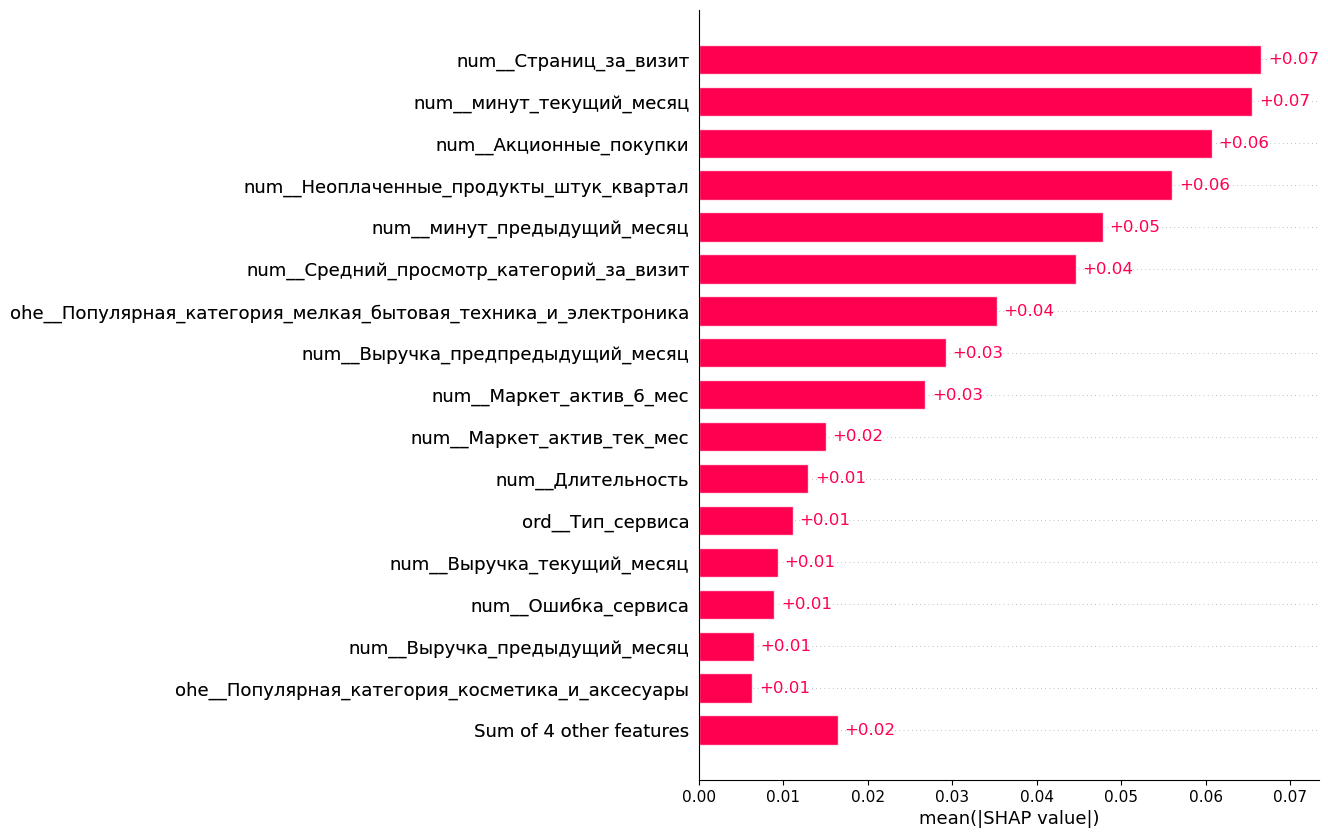

In [74]:
shap.plots.bar(shap_values[..., 1], max_display=17) 

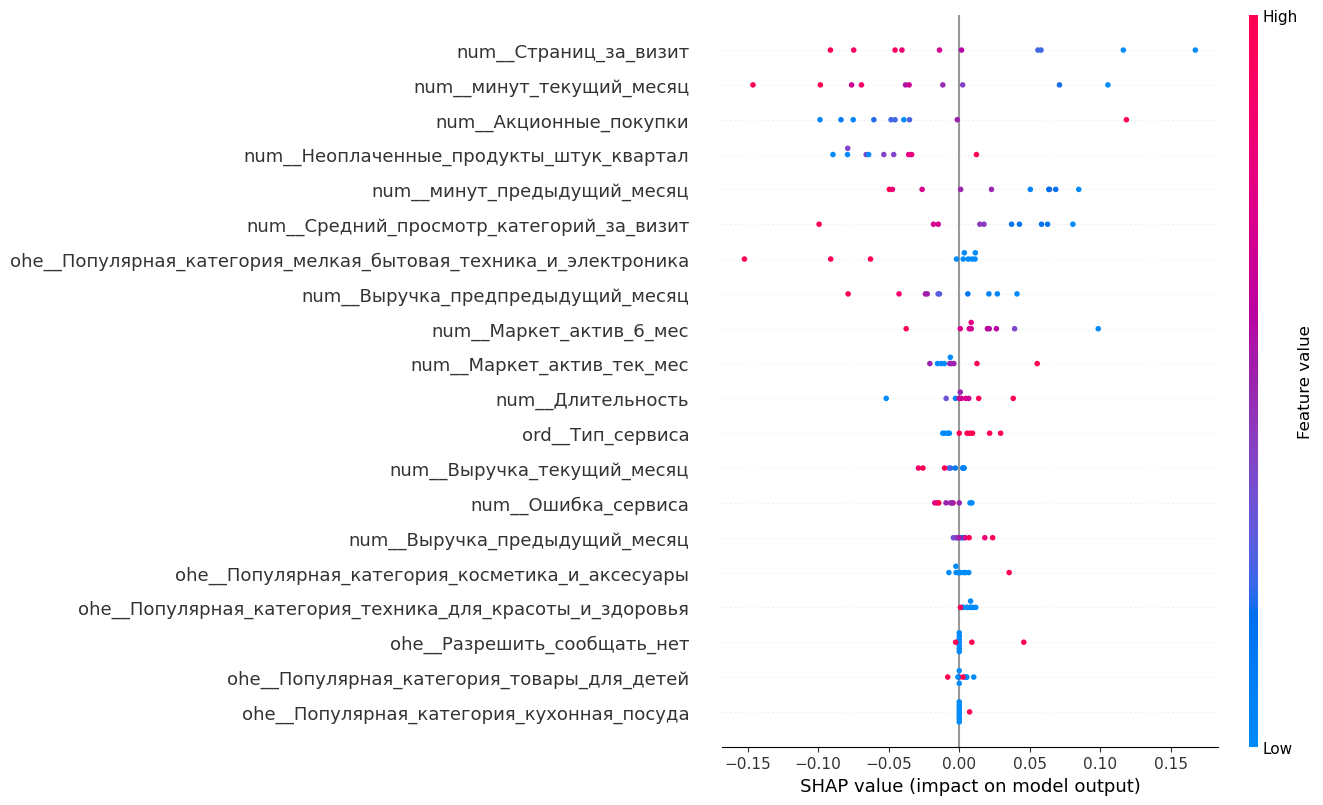

In [75]:
shap.plots.beeswarm(shap_values[..., 1], max_display=22) 

### Выводы о значимости признаков

1. Признаки, мало значимые для модели:
* выручка за предыдущий месяц
* тип сервиса (Стандарт)
* количество маркетинговых коммуникаций в текущем месяце
* выручка за текущий месяц
* Популярная_категория (косметика и аксессуары)
* время, которое покупатель провёл на сайте за предпредыдущий месяц

2. Признаки, которые сильнее всего влияют на целевой признак (снижение польз. активности)
* количество страниц, которые просмотрел покуп-ль за один визит на сайт за 3 мес. (низкие значения)
* сколько в среднем категорий покуп-ль просмотрел за визит в теч. последн. месяца (низкие значения)
* время, которое покупатель провёл на сайте за предыдущий месяц (низкие значения)
* время, которое покупатель провёл на сайте за текущий месяц (низкие значения)
* среднемесячная доля покупок по акции от общего числа покупок за посл. 6 мес. (высокие значения)
* общее число неоплаченных товаров в корзине за последние 3 месяца (высокие значения)

3. При моделировании и принятии бизнес-решений можно использовать эти наблюдения
следующим образом. Для мотивации пользователей сохранить прежний уровень активности
имеет смысл: 
* повысить вовлеченность пользователя в навигацию по сайту. Сделать его более удобным, эргономичным.
Для этого, в числе прочего, можно собрать информацию об использовании разделов сайта пользователями
и проанализировать ее.
* пересмотреть политику по акциям: активность пользователей, покупающих товары в основном по акциям, склонна к снижению
* пересмотреть политику по маркетинговым коммуникациям - снизить напор, вызывающий отторжение

## Сегментация покупателей

### Соединение данных моделирования с данными о прибыльности покупателей

Рассчитаем вероятность снижения клиентской активности в тестовой выборке и соединим ее с данными о прибыльности покупателей (используя id, ранее восстановленный из индекса). 

In [76]:
model_data = X_test
model_data['вероятность_снижения'] = model.predict_proba(model_data)[:,1]

In [77]:
model_data.head()

,ohe__Разрешить_сообщать_нет,ohe__Популярная_категория_косметика_и_аксесуары,ohe__Популярная_категория_кухонная_посуда,ohe__Популярная_категория_мелкая_бытовая_техника_и_электроника,ohe__Популярная_категория_техника_для_красоты_и_здоровья,ohe__Популярная_категория_товары_для_детей,ord__Тип_сервиса,num__Маркет_актив_6_мес,num__Маркет_актив_тек_мес,num__Длительность,num__Акционные_покупки,num__Средний_просмотр_категорий_за_визит,num__Неоплаченные_продукты_штук_квартал,num__Ошибка_сервиса,num__Страниц_за_визит,num__Выручка_текущий_месяц,num__Выручка_предыдущий_месяц,num__Выручка_предпредыдущий_месяц,num__минут_текущий_месяц,num__минут_предыдущий_месяц,вероятность_снижения
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.561404,0.5,0.506263,0.045455,1.0,0.1,0.444444,0.578947,0.105243,0.272145,0.520128,0.684211,0.611111,0.031883
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.087719,0.5,0.587683,0.943182,0.4,0.6,0.111111,0.263158,0.280120,0.165347,0.356550,0.263158,0.333333,0.974973
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.421053,0.5,0.383090,0.022727,0.6,0.2,0.888889,0.473684,0.709644,0.641789,0.298403,0.368421,0.833333,0.122035
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.456140,0.0,0.977035,0.272727,0.6,0.3,0.555556,0.263158,0.793541,0.933283,0.571885,0.263158,0.222222,0.890886
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.807018,0.5,0.027140,1.000000,0.0,0.2,0.333333,0.315789,0.598151,0.552833,0.225559,0.736842,0.555556,0.598306


In [78]:
model_data = pd.concat([X_test_id, model_data], axis=1)

In [79]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [80]:
model_data_money = model_data.merge(money, on='id', how='left')

In [81]:
model_data_money.head()

,id,ohe__Разрешить_сообщать_нет,ohe__Популярная_категория_косметика_и_аксесуары,ohe__Популярная_категория_кухонная_посуда,ohe__Популярная_категория_мелкая_бытовая_техника_и_электроника,ohe__Популярная_категория_техника_для_красоты_и_здоровья,ohe__Популярная_категория_товары_для_детей,ord__Тип_сервиса,num__Маркет_актив_6_мес,num__Маркет_актив_тек_мес,num__Длительность,num__Акционные_покупки,num__Средний_просмотр_категорий_за_визит,num__Неоплаченные_продукты_штук_квартал,num__Ошибка_сервиса,num__Страниц_за_визит,num__Выручка_текущий_месяц,num__Выручка_предыдущий_месяц,num__Выручка_предпредыдущий_месяц,num__минут_текущий_месяц,num__минут_предыдущий_месяц,вероятность_снижения,Прибыль
0,216161,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.561404,0.5,0.506263,0.045455,1.0,0.1,0.444444,0.578947,0.105243,0.272145,0.520128,0.684211,0.611111,0.031883,4.69
1,215654,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.087719,0.5,0.587683,0.943182,0.4,0.6,0.111111,0.263158,0.280120,0.165347,0.356550,0.263158,0.333333,0.974973,2.75
2,216307,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.421053,0.5,0.383090,0.022727,0.6,0.2,0.888889,0.473684,0.709644,0.641789,0.298403,0.368421,0.833333,0.122035,3.16
3,215501,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.456140,0.0,0.977035,0.272727,0.6,0.3,0.555556,0.263158,0.793541,0.933283,0.571885,0.263158,0.222222,0.890886,3.74
4,215934,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.807018,0.5,0.027140,1.000000,0.0,0.2,0.333333,0.315789,0.598151,0.552833,0.225559,0.736842,0.555556,0.598306,4.40


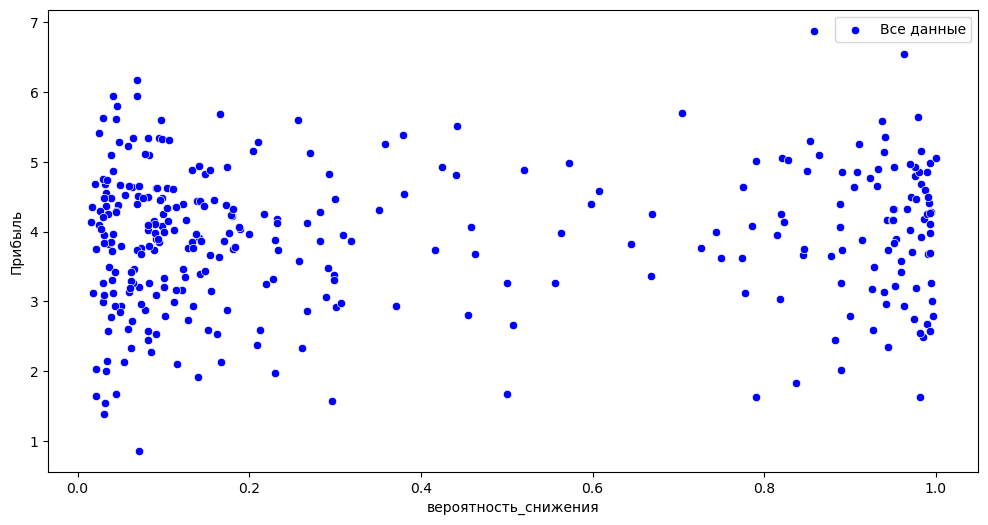

In [82]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=model_data_money, x='вероятность_снижения', y='Прибыль', label='Все данные', color='blue')
plt.legend()
plt.show()

### Сегментирование (кластеризация)

Создадим сегмент путем отбора клиентов, для которых модель прогнозирует высокую (выше определенного порога, выбранного экспертным путем) вероятность снижения покупательской активности и высокую прибыль.

В качестве такого значения, на основании результатов шага 8.1 (см. диаграмму рассеяния), выберем:
- порог вероятность снижения покупательской активности = 0.7
- порог по прибыли = 2.5

По этим порогам хорошо выделяется сегмент в правой верхней части диаграммы.

In [83]:
seg = model_data_money.query('вероятность_снижения > 0.7 and Прибыль > 2.5')
rest = model_data_money.query('вероятность_снижения <= 0.7 or Прибыль <= 2.5')

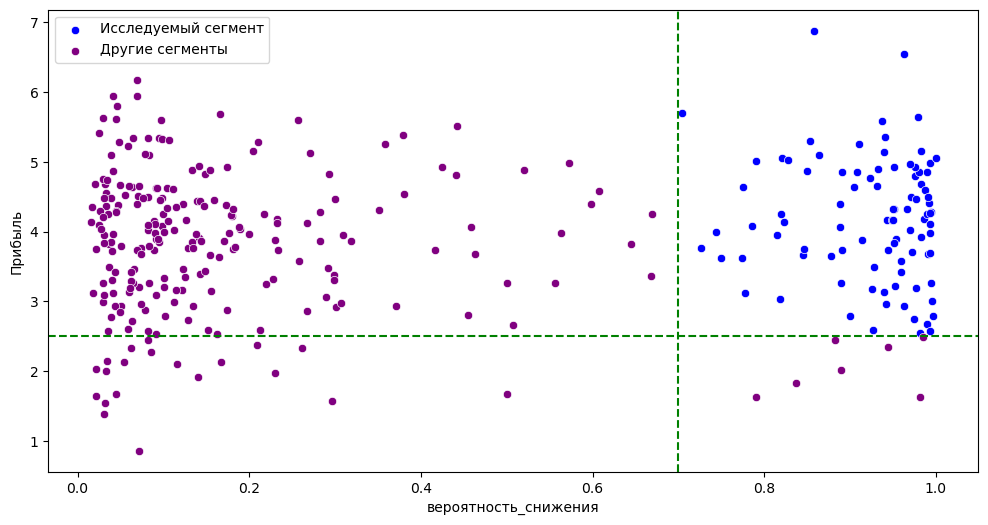

In [84]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=seg, x='вероятность_снижения', y='Прибыль', label='Исследуемый сегмент', color='blue')
sns.scatterplot(data=rest, x='вероятность_снижения', y='Прибыль', label='Другие сегменты', color='purple')
plt.legend()
plt.axvline(x=0.7, color='green', linestyle='--')
plt.axhline(y=2.5, color='green', linestyle='--')
plt.show()

Сравним клиентов из сегмента и клиентов которые в этот сегмент не входят.

Для этого - определяем группу клиентов по определенному признаку  
и посмотрим, как клиенты из исследуемого сегмента отличаются в этой группе от той же группы вне сегмента.
Смотреть будем по следующим признакам:
- группа товаров;
- покупки по акции.

Цель: 
- посмотреть: какие факторы влияют на увеличение вероятности снижения активности и на уменьшение прибыли; 
- дать рекомендации по удержанию клиентов.

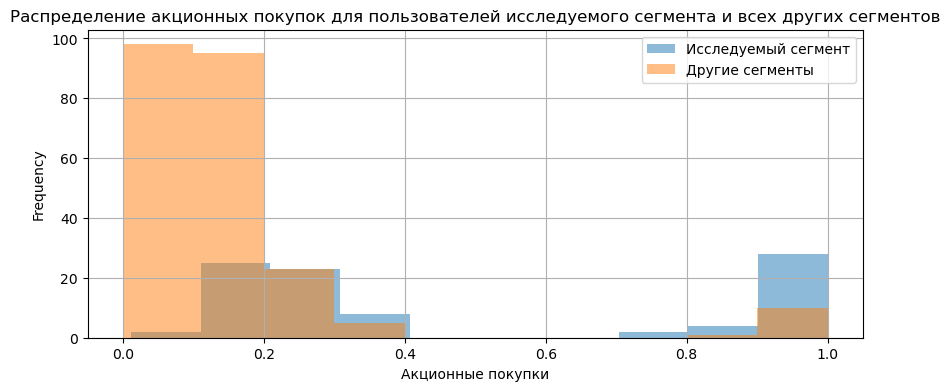

In [85]:
plt.figure(figsize=(10, 4))
plt.hist(seg.num__Акционные_покупки, alpha=0.5, label='Исследуемый сегмент')
plt.hist(rest.num__Акционные_покупки, alpha=0.5, label='Другие сегменты')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('Акционные покупки')
plt.ylabel('Frequency')
plt.title('Распределение акционных покупок для пользователей исследуемого сегмента и всех других сегментов')
plt.show()

Проводимые акции не оказывают заметного влияния на вероятность снижения активности. 

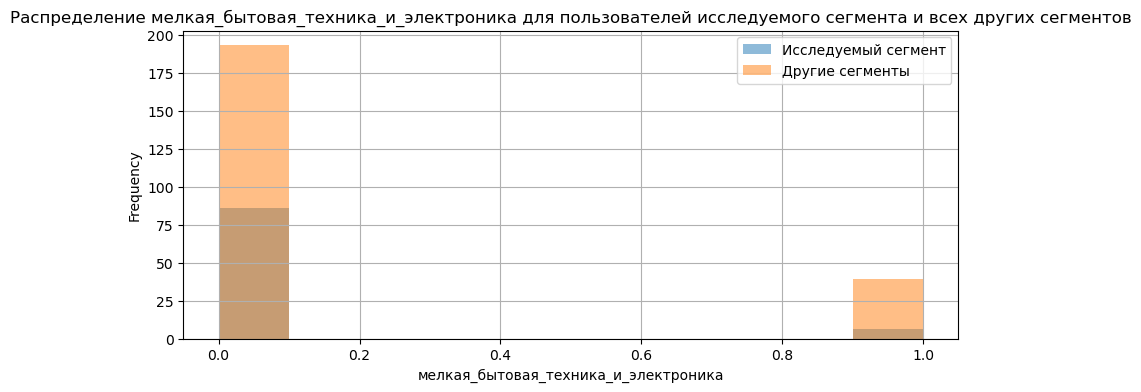

In [86]:
plt.figure(figsize=(10, 4))
plt.hist(seg.ohe__Популярная_категория_мелкая_бытовая_техника_и_электроника, alpha=0.5, label='Исследуемый сегмент')
plt.hist(rest.ohe__Популярная_категория_мелкая_бытовая_техника_и_электроника, alpha=0.5, label='Другие сегменты')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('мелкая_бытовая_техника_и_электроника')
plt.ylabel('Frequency')
plt.title('Распределение мелкая_бытовая_техника_и_электроника для пользователей исследуемого сегмента и всех других сегментов')
plt.show()

В нашем сегменте мало тех, покупает мелкую бытовую технику и электронику.

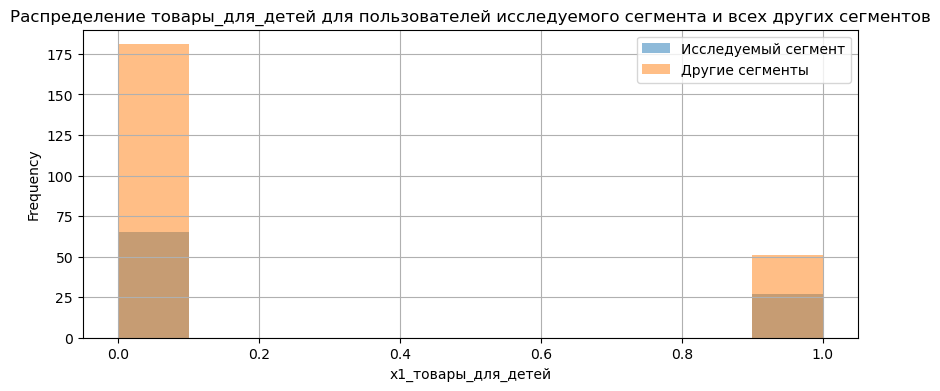

In [87]:
plt.figure(figsize=(10, 4))
plt.hist(seg.ohe__Популярная_категория_товары_для_детей, alpha=0.5, label='Исследуемый сегмент')
plt.hist(rest.ohe__Популярная_категория_товары_для_детей, alpha=0.5, label='Другие сегменты')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('x1_товары_для_детей')
plt.ylabel('Frequency')
plt.title('Распределение товары_для_детей для пользователей исследуемого сегмента и всех других сегментов')
plt.show()

Влияние покупки товаров для детей - слабое.

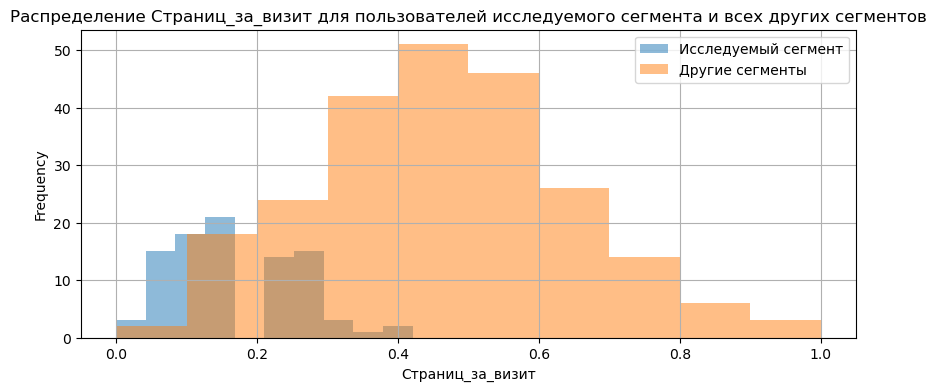

In [88]:
plt.figure(figsize=(10, 4))
plt.hist(seg.num__Страниц_за_визит, alpha=0.5, label='Исследуемый сегмент')
plt.hist(rest.num__Страниц_за_визит, alpha=0.5, label='Другие сегменты')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('Страниц_за_визит')
plt.ylabel('Frequency')
plt.title('Распределение Страниц_за_визит для пользователей исследуемого сегмента и всех других сегментов')
plt.show()

Влияние количества просмотров страниц за визит на сайте - сильное.

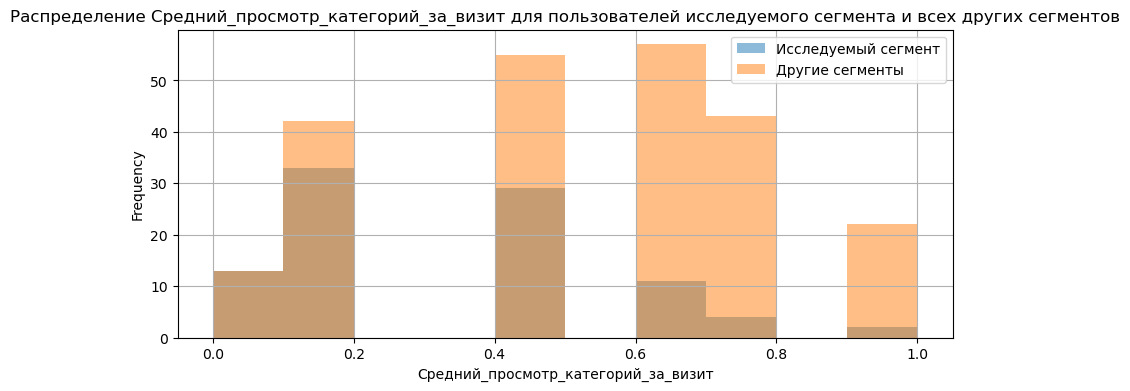

In [89]:
plt.figure(figsize=(10, 4))
plt.hist(seg.num__Средний_просмотр_категорий_за_визит, alpha=0.5, label='Исследуемый сегмент')
plt.hist(rest.num__Средний_просмотр_категорий_за_визит, alpha=0.5, label='Другие сегменты')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('Средний_просмотр_категорий_за_визит')
plt.ylabel('Frequency')
plt.title('Распределение Средний_просмотр_категорий_за_визит для пользователей исследуемого сегмента и всех других сегментов')
plt.show()

Влияние количества просмотров категорий на сайте за визит - сильное.

## Общий вывод

**Общий вывод** 

Проведено исследование данных о продажах интернет-магазина «В один клик».
Проанализированы данные и разработано решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Пропусков в данных - нет. Дубликаты найдены и устранены. Типы данных - корректные.

Имеются выбросы в признаках: Маркет_актив_6_мес, Маркет_актив_тек_мес, Акционные_покупки, Неоплаченные_продукты_штук_квартал, Выручка, Прибыль

Дисбаланс имеется в признаках: Покупательская активность (дисбаланс небольшой, к тому же это целевой признак), Разрешить сообщать, Тип сервиса.

В таблице отсутствуют значения коллинеарности 0.9 и выше для всех пар признаков. Можно сделать вывод об отсутствии мультиколлинеарности.

Признаки, мало значимые для модели:
- выручка за предыдущий месяц
- тип сервиса (Стандарт)
- количество маркетинговых коммуникаций в текущем месяце
- выручка за текущий месяц
- Популярная_категория (косметика и аксессуары)
- время, которое покупатель провёл на сайте за предпредыдущий месяц

Признаки, которые сильнее всего влияют на целевой признак (снижение польз. активности)
- количество страниц, которые просмотрел покуп-ль за один визит на сайт за 3 мес. (низкие значения)
- сколько в среднем категорий покуп-ль просмотрел за визит в теч. последн. месяца (низкие значения)
- время, которое покупатель провёл на сайте за предыдущий месяц (низкие значения)
- время, которое покупатель провёл на сайте за текущий месяц (низкие значения)
- среднемесячная доля покупок по акции от общего числа покупок за посл. 6 мес. (высокие значения)
- общее число неоплаченных товаров в корзине за последние 3 месяца (высокие значения)

Дополнительно проведена сегментация покупателей: выделен сегмент клиентов, для которых модель прогнозирует высокую вероятность снижения покупательской активности и высокую прибыль.
Исследование было проведено по некоторым выбранным факторам и показало, что:
- проводимые акции не оказывают заметного влияния на вероятность снижения активности в данном сегменте.
- в данном сегменте мало тех, покупает мелкую бытовую технику и электронику.
- влияние покупки товаров для детей - слабое.
- влияние количества просмотров страниц за визит на сайте - сильное.
- влияние количества просмотров категорий на сайте за визит - сильное.

При моделировании и принятии бизнес-решений можно использовать эти наблюдения следующим образом. Для мотивации пользователей сохранить прежний уровень активности имеет смысл:
1. Повысить вовлеченность пользователя в навигацию по сайту. Сделать его более удобным, эргономичным. Для этого, в числе прочего, можно собрать информацию об использовании разделов сайта пользователями и проанализировать ее.
2. Пересмотреть политику по акциям: активность пользователей, покупающих товары в основном по акциям, склонна к снижению.
3. Пересмотреть политику по маркетинговым коммуникациям - снизить напор, вызывающий отторжение.